In [1]:
import os
import logging
import pandas as pd
import numpy as np

from dotenv import load_dotenv
from sqlalchemy import create_engine

from neuralforecast import NeuralForecast # type: ignore
from neuralforecast.auto import AutoTimeMixer  # type: ignore
from neuralforecast.models import TimeMixer, SOFTS  # type: ignore
from neuralforecast.losses.pytorch import HuberLoss  # type: ignore

# warm up

In [11]:
from neuralforecast.utils import AirPassengersDF

Y_df = AirPassengersDF  # Defined in neuralforecast.utils
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


In [30]:
Y_df.tail()

,unique_id,ds,y
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0
143,1.0,1960-12-31,432.0


In [24]:
from neuralforecast.models import LSTM, NHITS, RNN

In [25]:
horizon = 12

# Try different hyperparmeters to improve accuracy.
models = [
    LSTM(
        h=horizon,  # Forecast horizon
        max_steps=500,  # Number of steps to train
        scaler_type="standard",  # Type of scaler to normalize data
        encoder_hidden_size=64,  # Defines the size of the hidden state of the LSTM
        decoder_hidden_size=64,
    ),  # Defines the number of hidden units of each layer of the MLP decoder
    NHITS(
        h=horizon,  # Forecast horizon
        input_size=2 * horizon,  # Length of input sequence
        max_steps=100,  # Number of steps to train
        n_freq_downsample=[2, 1, 1],
    ),  # Downsampling factors for each stack output
]
nf = NeuralForecast(models=models, freq="M")
nf.fit(df=Y_df)

Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/jx/ProgramData/python/marten/notebooks/TimeMixer/lightning_logs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 50.4 K | train
4 | context_adapter | Linear        | 7.8 K  | train
5 | mlp_decoder     | MLP           | 769    | train
----------------------------------------------------------
59.0 K    Trainable params
0         Non-trainable params
59.0 K    Total params
0.236     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.769     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.


In [26]:
Y_hat_df = nf.predict()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [28]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS
0,1.0,1961-01-31,430.598083,448.240448
1,1.0,1961-02-28,450.796326,437.499115
2,1.0,1961-03-31,462.560730,481.898010
3,1.0,1961-04-30,473.795441,501.486908
4,1.0,1961-05-31,512.449402,514.598633


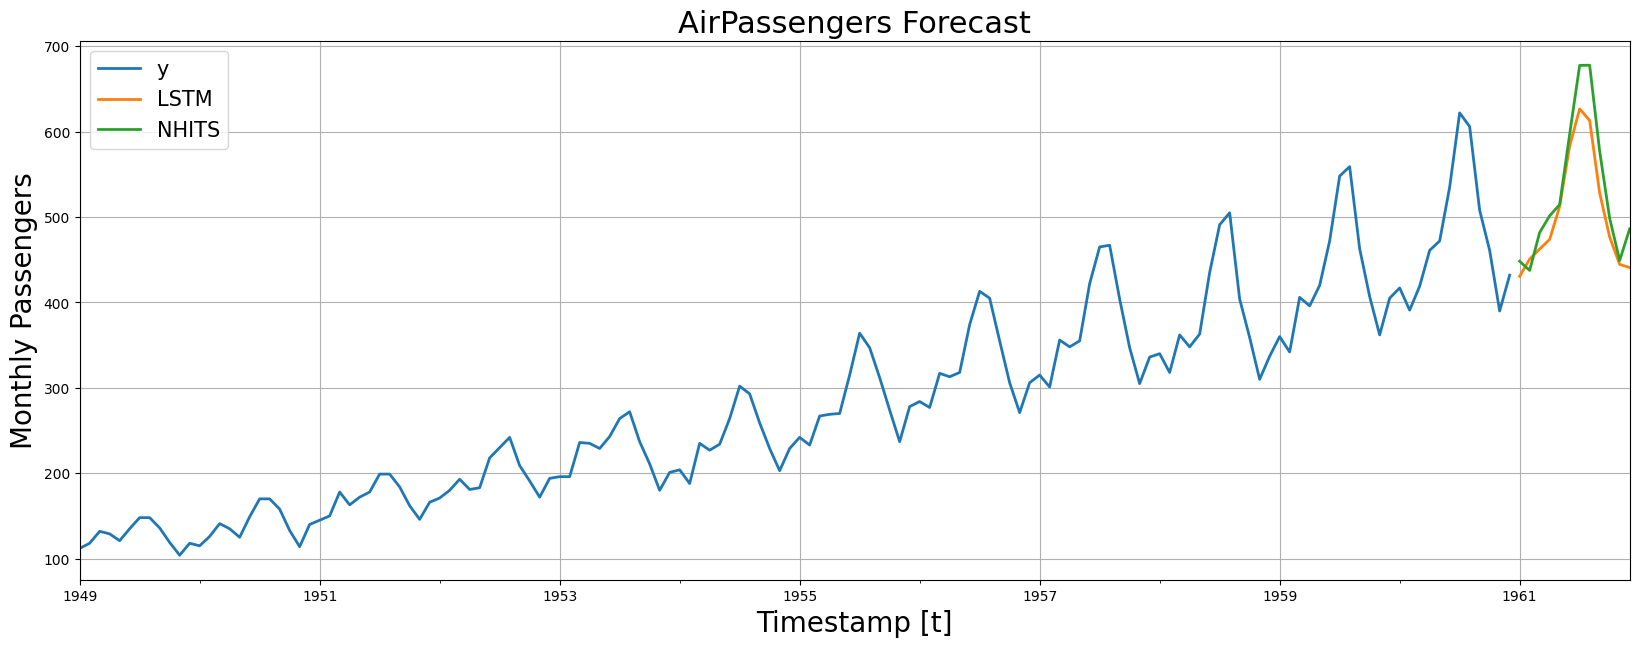

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
plot_df = pd.concat([Y_df, Y_hat_df]).set_index(
    "ds"
)  # Concatenate the train and forecast dataframes
plot_df[["y", "LSTM", "NHITS"]].plot(ax=ax, linewidth=2)

ax.set_title("AirPassengers Forecast", fontsize=22)
ax.set_ylabel("Monthly Passengers", fontsize=20)
ax.set_xlabel("Timestamp [t]", fontsize=20)
ax.legend(prop={"size": 15})
ax.grid()

Seed set to 1
Seed set to 1
/Users/jx/ProgramData/git/neuralforecast/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.751     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


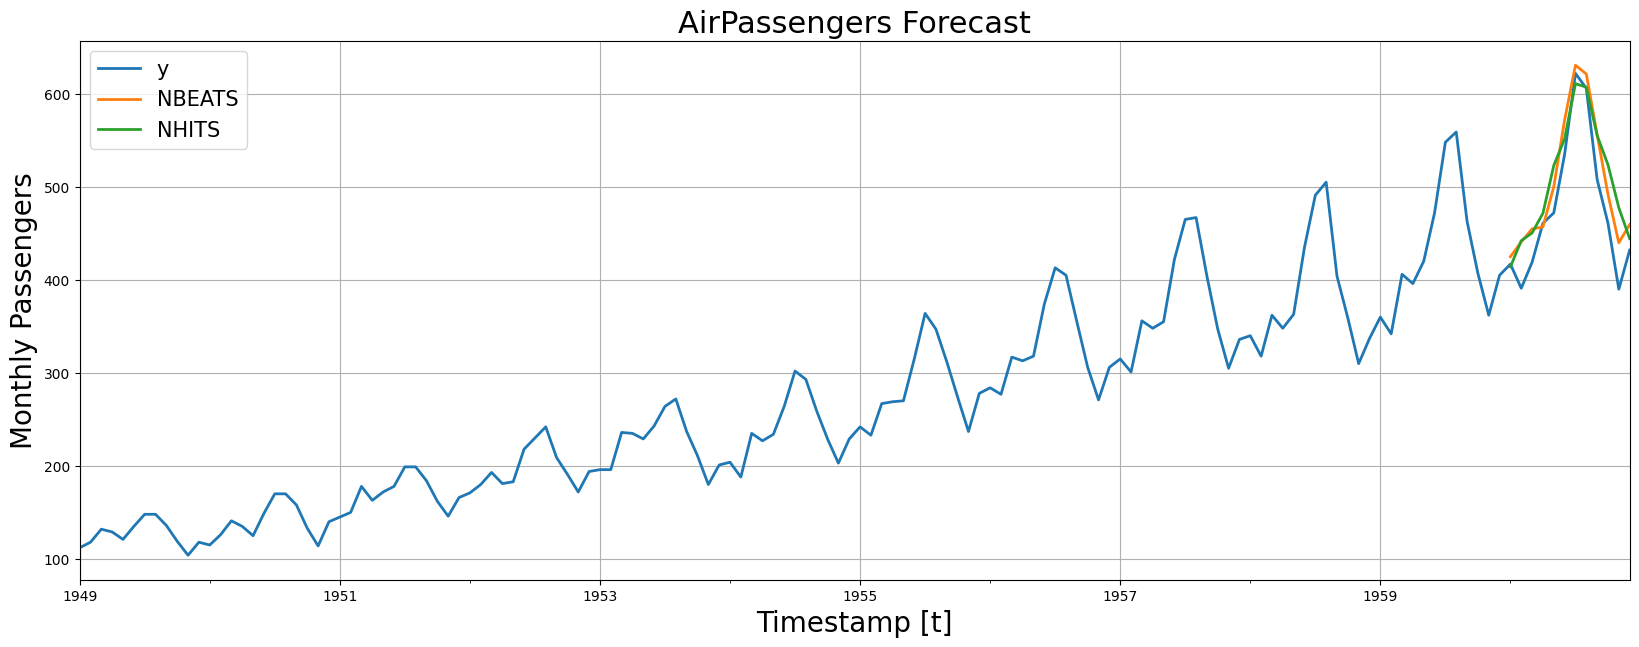

In [31]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF

# Split data and declare panel dataset
Y_df = AirPassengersDF
Y_train_df = Y_df[Y_df.ds <= "1959-12-31"]  # 132 train
Y_test_df = Y_df[Y_df.ds > "1959-12-31"]  # 12 test

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [
    NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
    NHITS(input_size=2 * horizon, h=horizon, max_steps=50),
]
nf = NeuralForecast(models=models, freq="M")
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how="left", on=["unique_id", "ds"])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index("ds")

plot_df[["y", "NBEATS", "NHITS"]].plot(ax=ax, linewidth=2)

ax.set_title("AirPassengers Forecast", fontsize=22)
ax.set_ylabel("Monthly Passengers", fontsize=20)
ax.set_xlabel("Timestamp [t]", fontsize=20)
ax.legend(prop={"size": 15})
ax.grid()

## TimeMixer

In [1]:
from lightning_fabric.utilities import seed

seed.log.name

'lightning_fabric.utilities.seed'

In [14]:
# model = AutoTimeMixer(h=20, n_series=len(df), num_samples=2)
tmx = TimeMixer(
    h=10,
    n_series=1,
    input_size=10,
    # d_model=64,
    # d_ff=64,
    # e_layers=6,
    # top_k=6,
    # batch_size=64,
    loss=HuberLoss(),
    early_stop_patience_steps=5,
    scaler_type="standard",
)

nf = NeuralForecast(
    models=[tmx],
    freq="M",
    # Scaler to apply per-serie to all features before fitting, which is inverted after predicting.
    # Can be 'standard', 'robust', 'robust-iqr', 'minmax' or 'boxcox'
    local_scaler_type=None,
)

Seed set to 1


In [15]:
cv_result = nf.cross_validation(
    Y_df,
    # n_windows=5,
    val_size=10,
    verbose=True,
    refit=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                 | Params | Mode 
--------------------------------------------------------------------
0  | loss              | HuberLoss            | 0      | train
1  | padder            | ConstantPad1d        | 0      | train
2  | scaler            | TemporalNorm         | 0      | train
3  | pdm_blocks        | ModuleList           | 18.2 K | train
4  | preprocess        | SeriesDecomp         | 0      | train
5  | enc_embedding     | DataEmbedding_wo_pos | 2.5 K  | train
6  | normalize_layers  | ModuleList           | 4      | train
7  | predict_layers    | ModuleList           | 170    | train
8  | projection_layer  | Linear               | 33     | train
9  | out_res_layers    | ModuleList           | 140    | train
10 | regression_layers | ModuleList           | 170    | train
---------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using stored dataset.


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [16]:
pis = nf.predict_insample()

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

ValueError: could not broadcast input array from shape (1150,1) into shape (1250,1)

# Real code

In [2]:
load_dotenv()  # take environment variables from .env.

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
db_url = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

alchemyEngine = create_engine(
    db_url,
    pool_recycle=3600,
)

In [3]:
# query = """
# with cte as (
# SELECT "date", "open", "close", high, low, volume, amount, open_preclose_rate, high_preclose_rate, low_preclose_rate, vol_change_rate, amt_change_rate, change_rate
# FROM index_daily_em_view
# where symbol = '399673'
# order by date desc
# limit 1200
# ) select * from cte order by date
# """
query = """
with cte as (
SELECT "date", "open", "close", high, low, volume, amount, open_preclose_rate, high_preclose_rate, low_preclose_rate, vol_change_rate, amt_change_rate, change_rate
FROM index_daily_em_view 
where symbol = '399673'
and change_rate is not null
) select * from cte order by date
"""

raw_df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

In [4]:
df = raw_df.rename(columns={"date":"ds", "change_rate":"y"})
df.insert(0, "unique_id", "399673")

In [5]:
df.dtypes

unique_id                     object
ds                    datetime64[ns]
open                         float64
close                        float64
high                         float64
low                          float64
volume                       float64
amount                       float64
open_preclose_rate           float64
high_preclose_rate           float64
low_preclose_rate            float64
vol_change_rate              float64
amt_change_rate              float64
y                            float64
dtype: object

In [5]:
len(df)

2485

In [6]:
df_train = df

In [21]:
# handle univariate first, to avoid the following error
# 'DataFrame' object has no attribute 'temporal_cols'
df_train = df[["unique_id", "ds", "y", "open_preclose_rate"]]
df_train.tail()

,unique_id,ds,y,open_preclose_rate
2479,399673,2024-08-23,0.05667,-0.48135
2480,399673,2024-08-26,-0.11727,0.31184
2481,399673,2024-08-27,-0.87590,-0.56837
2482,399673,2024-08-28,-0.06461,-0.27391
2483,399673,2024-08-29,0.50911,-1.45864


In [7]:
# handle univariate first, to avoid the following error
# 'DataFrame' object has no attribute 'temporal_cols'
df_train = df[["unique_id", "ds", "y"]]

In [42]:
# model = AutoTimeMixer(h=20, n_series=len(df), num_samples=2)
seed_logger = logging.getLogger("lightning_fabric.utilities.seed")
orig_seed_log_level = seed_logger.getEffectiveLevel()
seed_logger.setLevel(logging.FATAL)

tmx = TimeMixer(
    h=20,
    n_series=1,
    input_size=100,
    channel_independence=1, # 0 / 1
    random_seed=7,
    # NOTE: exogenous is not supported
    # futr_exog_list=[
    #     "open",
    #     "close",
    #     "high",
    #     "low",
    #     "volume",
    #     "amount",
    #     "open_preclose_rate",
    #     "high_preclose_rate",
    #     "low_preclose_rate",
    #     "vol_change_rate",
    #     "amt_change_rate",
    # ],
    # futr_exog_list=["open_preclose_rate"],
    # d_model=64,
    # d_ff=64,
    # e_layers=6,
    # top_k=6,
    # batch_size=64,
    # loss=HuberLoss(),
    early_stop_patience_steps=5,
    # scaler_type="standard",
    enable_progress_bar=False,
    enable_model_summary=False,
    # num_sanity_val_steps=0,
    # accelerator="cpu",
)

nf = NeuralForecast(
    models=[tmx],
    freq="B",
    # Scaler to apply per-series to all features before fitting, which is inverted after predicting.
    # Can be 'standard', 'robust', 'robust-iqr', 'minmax' or 'boxcox'
    # local_scaler_type=None,
)

seed_logger.setLevel(orig_seed_log_level)

In [7]:
sft = SOFTS(
    h=20,
    n_series=1,
    input_size=60,
    early_stop_patience_steps=5,
    hist_exog_list=["open_preclose_rate"],
    # scaler_type="standard"
)
nf = NeuralForecast(
    models=[sft],
    freq="B",
    # Scaler to apply per-serie to all features before fitting, which is inverted after predicting.
    # Can be 'standard', 'robust', 'robust-iqr', 'minmax' or 'boxcox'
    # local_scaler_type=None,
)

Seed set to 1


In [31]:
# model = AutoTimeMixer(h=20, n_series=len(df), num_samples=2)
tmx = TimeMixer(
    h=20,
    n_series=1,
    input_size=60,
    # d_model=64,
    # d_ff=64,
    # e_layers=6,
    # top_k=6,
    # batch_size=64,
    early_stop_patience_steps=5,
    scaler_type="standard",
)
sft = SOFTS(
    h=20, n_series=1, input_size=60, early_stop_patience_steps=5, scaler_type="standard"
)
nf = NeuralForecast(
    models=[tmx, sft],
    freq="B",
    # Scaler to apply per-serie to all features before fitting, which is inverted after predicting.
    # Can be 'standard', 'robust', 'robust-iqr', 'minmax' or 'boxcox'
    # local_scaler_type=None,
)

Seed set to 1
Seed set to 1


In [43]:
nf.fit(
    df_train, 
    use_init_models=True,
    val_size=200,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [44]:
nf.models[0].metrics

{'train_loss': tensor(1.3861),
 'train_loss_step': tensor(1.3861),
 'train_loss_epoch': tensor(1.3861),
 'valid_loss': tensor(1.3116),
 'ptl/val_loss': tensor(1.3116)}

In [11]:
nf.models[0]

TimeMixer

In [45]:
metrics = nf.models[0].metrics

In [46]:
float(metrics["train_loss"])

1.386099934577942

In [47]:
float(metrics["valid_loss"])

1.3116085529327393

In [13]:
print(f"{nf.models[0].loss}  {nf.models[0].valid_loss}")

MAE()  MAE()


In [12]:
# list out all the attributes for `nf.models[0]`
attributes = dir(nf.models[0])
for attribute in attributes:
    print(attribute)

CHECKPOINT_HYPER_PARAMS_KEY
CHECKPOINT_HYPER_PARAMS_NAME
CHECKPOINT_HYPER_PARAMS_TYPE
EXOGENOUS_FUTR
EXOGENOUS_HIST
EXOGENOUS_STAT
SAMPLING_TYPE
T_destination
_LightningModule__check_allowed
_LightningModule__check_not_nested
_LightningModule__to_tensor
_TimeMixer__multi_scale_process_inputs
__annotations__
__call__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__jit_unused_properties__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_apply
_apply_batch_transfer_handler
_automatic_optimization
_backward_hooks
_backward_pre_hooks
_buffers
_call_batch_hook
_call_impl
_check_exog
_compiled_call_impl
_compiler_ctx
_create_windows
_current_fx_name
_device
_device_mesh
_dtype
_example_input_array
_fabric
_fabric_optimizers
_fit
_fit_distributed
_forward_hooks
_forward_hooks_always_call

In [48]:
train_losses = nf.models[0].train_trajectories
train_losses

[(0, 1.2652792930603027),
 (1, 1.4556605815887451),
 (2, 1.913306474685669),
 (3, 1.648797631263733),
 (4, 1.6551233530044556),
 (5, 1.3696376085281372),
 (6, 1.5856698751449585),
 (7, 1.5500593185424805),
 (8, 1.4477684497833252),
 (9, 1.6019489765167236),
 (10, 1.5306743383407593),
 (11, 1.6930204629898071),
 (12, 1.2258554697036743),
 (13, 1.426756739616394),
 (14, 1.477355718612671),
 (15, 1.4579471349716187),
 (16, 1.6078250408172607),
 (17, 1.4272948503494263),
 (18, 1.4014198780059814),
 (19, 1.6109946966171265),
 (20, 1.7012355327606201),
 (21, 1.4736907482147217),
 (22, 1.4918445348739624),
 (23, 1.5586013793945312),
 (24, 1.4386353492736816),
 (25, 1.4953359365463257),
 (26, 1.3780930042266846),
 (27, 1.5182558298110962),
 (28, 1.455914855003357),
 (29, 1.5370842218399048),
 (30, 1.5447022914886475),
 (31, 1.468395471572876),
 (32, 1.3750426769256592),
 (33, 1.3290830850601196),
 (34, 1.4182649850845337),
 (35, 1.4127308130264282),
 (36, 1.5263346433639526),
 (37, 1.618616819

In [49]:
valid_losses = nf.models[0].valid_trajectories
valid_losses

[(0, 1.2441478967666626),
 (100, 1.2389733791351318),
 (200, 1.2499414682388306),
 (300, 1.2595993280410767),
 (400, 1.2697396278381348),
 (500, 1.314969778060913),
 (600, 1.3116085529327393)]

In [16]:
train_losses = nf.models[1].train_trajectories
train_losses

IndexError: list index out of range

In [50]:
# get the smallest loss from `train_losses`, which is a list of 2-element tuples, and the 2nd element is loss value.
smallest_loss = min(train_losses, key=lambda x: x[1])[1]
smallest_loss

1.1313724517822266

In [51]:
min(valid_losses, key=lambda x: x[1])[1]


1.2389733791351318

In [37]:
valid_losses = nf.models[1].valid_trajectories
valid_losses

[(0, 0.9060361981391907),
 (100, 0.7217851877212524),
 (200, 0.8186995387077332),
 (300, 0.7362855672836304),
 (400, 0.8162698149681091),
 (500, 0.7545660138130188),
 (600, 0.7777147889137268)]

In [ ]:
# nf = NeuralForecast(models=models, freq="M")
# nf.fit(df=Y_df)

## cross validation

In [94]:
import warnings
import logging
# from lightning_utilities.core import rank_zero
# rank_zero.log.setLevel(logging.FATAL)
# print(rank_zero.log.name)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    cv_result = nf.cross_validation(
        df,
        # n_windows=5,
        val_size=200,
        verbose=False,
        refit=True,
    )

/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [95]:
cv_result

,ds,cutoff,TimeMixer,y
unique_id,,,,
399673,2024-07-16,2024-07-15,0.661896,1.73321
399673,2024-07-17,2024-07-15,-0.175834,-0.13771
399673,2024-07-18,2024-07-15,-1.224096,1.41925
399673,2024-07-19,2024-07-15,0.432683,0.36158
399673,2024-07-22,2024-07-15,0.767579,0.00480
399673,2024-07-23,2024-07-15,-0.553260,-2.92943
399673,2024-07-24,2024-07-15,1.030751,-1.15045
399673,2024-07-25,2024-07-15,2.444690,-0.45666
399673,2024-07-26,2024-07-15,-2.068262,0.95078


## Evaluate

In [45]:
from utilsforecast.losses import mae, mse, rmse
from utilsforecast.evaluation import evaluate

In [46]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=["unique_id", "ds", "cutoff", "y"]).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.
    for cutoff in df["cutoff"].unique():
        eval_ = evaluate(df[df["cutoff"] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby("unique_id").mean(
        numeric_only=True
    )  # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals["best_model"] = evals.idxmin(axis=1)
    return evals

In [58]:
cv_result.reset_index(inplace=True)

In [28]:
cv_result.columns

Index(['unique_id', 'ds', 'cutoff', 'TimeMixer', 'y'], dtype='object')

In [62]:
evaluation_df = evaluate_cross_validation(cv_result, mae)
evaluation_df.head()

,TimeMixer,best_model
unique_id,,
399673,1.609029,TimeMixer


In [65]:
evaluation_df = evaluate_cross_validation(cv_result, rmse)
evaluation_df.head()

,TimeMixer,best_model
unique_id,,
399673,1.954461,TimeMixer


## Predict

### InSample

In [123]:
forecast = nf.predict_insample()

/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [124]:
forecast

,ds,cutoff,TimeMixer,y
unique_id,,,,
399673,2014-06-19,2014-06-18,-0.000678,-3.59110
399673,2014-06-20,2014-06-18,-0.000023,1.08187
399673,2014-06-23,2014-06-18,0.000082,2.25177
399673,2014-06-24,2014-06-18,0.000594,0.54677
399673,2014-06-25,2014-06-18,-0.000140,-0.64595
...,...,...,...,...
399673,2024-08-06,2024-07-15,0.843638,1.34595
399673,2024-08-07,2024-07-15,-1.120043,-0.43949
399673,2024-08-08,2024-07-15,-0.022611,-0.72095


In [ ]:
forecast[forecast["cutoff"]=="2014-06-18"]

In [104]:
forecast[forecast["cutoff"] == "2024-08-12"]

,ds,cutoff,TimeMixer,y
unique_id,,,,


In [ ]:
forecast[forecast["cutoff"] == "2024-06-13"]

In [126]:
forecast.reset_index(inplace=True)

In [127]:
evaluation_df = evaluate_cross_validation(forecast[:-200], mae)
# evaluation_df.head()
evaluation_df

,TimeMixer,best_model
unique_id,,
399673,1.136189,TimeMixer


In [128]:
# exclude the last 200 elements of `forecast`
evaluation_df = evaluate_cross_validation(forecast[-200:], mae)
evaluation_df

,TimeMixer,best_model
unique_id,,
399673,1.0024,TimeMixer


In [51]:
evaluation_df = evaluate_cross_validation(forecast, rmse)
evaluation_df.head()

,TimeMixer,best_model
unique_id,,
399673,1.365567,TimeMixer


In [52]:
forecast = nf.predict(df)
forecast

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/jx/ProgramData/git/neuralforecast/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,TimeMixer
unique_id,,
399673,2024-08-13,0.428260
399673,2024-08-14,0.541052
399673,2024-08-15,-0.068153
399673,2024-08-16,0.509878
399673,2024-08-19,1.428220
399673,2024-08-20,-0.120020
399673,2024-08-21,0.113757
399673,2024-08-22,0.181160
399673,2024-08-23,-0.503133


In [55]:
# calculate cumulative returns on `TimeMixer` column in the `forecast` dataframe. The column is the change rate. The dataframe has a `ds` column of dates, in ascending order.
forecast['Cumulative_Returns'] = (1 + forecast['TimeMixer']).cumprod() - 1

In [56]:
forecast

,ds,TimeMixer,TimeMixer_cumprod,Cumulative_Returns
unique_id,,,,
399673,2024-08-13,0.428260,4.282601e-01,0.428260
399673,2024-08-14,0.541052,2.317110e-01,1.201023
399673,2024-08-15,-0.068153,-1.579172e-02,1.051017
399673,2024-08-16,0.509878,-8.051851e-03,2.096786
399673,2024-08-19,1.428220,-1.149981e-02,6.519679
399673,2024-08-20,-0.120020,1.380205e-03,5.617168
399673,2024-08-21,0.113757,1.570084e-04,6.369919
399673,2024-08-22,0.181160,2.844371e-05,7.705057
399673,2024-08-23,-0.503133,-1.431097e-05,3.325257


In [2]:
def get_all_subclasses(cls):
    subclasses = cls.__subclasses__()
    all_subclasses = []
    for subclass in subclasses:
        all_subclasses.append(subclass)
        all_subclasses.extend(get_all_subclasses(subclass))
    return all_subclasses

In [5]:
from marten.models.base_model import BaseModel
get_all_subclasses(BaseModel)

[marten.models.time_mixer.TimeMixerModel]

In [7]:
from marten.models.time_mixer import TimeMixerModel
from marten.utils.softs import SOFTSPredictor
# issubclass(TimeMixerModel, BaseModel)
issubclass(SOFTSPredictor, BaseModel)


False

# Troubleshoot

## RuntimeError('The size of tensor a (71) must match the size of tensor b (70) at non-singleton dimension 2')

In [7]:
hparams_raw = {
    "batch_size": 256,
    "channel_independence": 1,
    "covar_dist": [
        0.0359319108063596,
        0.008853365990661298,
        0.07860373051477355,
        0.02554917032281963,
        0.0699620957654155,
        0.003250161909332283,
        0.14342132122609735,
        0.12021891815928026,
        0.003050634280588117,
        0.20400824537383025,
        0.008449927948178788,
        0.02298363302955512,
        0.014088001552195315,
        0.2616288831209128,
    ],
    "d_ff": 128,
    "d_model": 64,
    "decomp_method": "moving_avg",
    "down_sampling_layers": 5,
    "down_sampling_method": "conv",
    "down_sampling_window": 14,
    "dropout": 0.12205218826134473,
    "e_layers": 15,
    "early_stop_patience_steps": 7,
    "input_size": 986,
    "learning_rate": 0.0001176029777228087,
    "local_scaler_type": "robust",
    "moving_avg": 51,
    "optimizer": "Adam",
    "top_k": 6,
    "use_norm": False,
    "h": 20,
    "max_steps": 1000,
    "validate": True,
    "random_seed": 7,
    "accelerator": "cpu",
    "devices": 1,
}

In [8]:
# remove "validate", "covar_dist" from hparams_raw dict
validate = hparams_raw.pop('validate', None)
hparams_raw.pop('covar_dist', None)
local_scaler_type = hparams_raw.pop("local_scaler_type")

In [9]:
import torch
import torch.optim as optim
from torch.optim.optimizer import Optimizer

def _select_optimizer(**kwargs):
    match kwargs["optimizer"]:
        case "Adam":
            model_optim = optim.Adam
        case "AdamW":
            model_optim = optim.AdamW
        case "SGD":
            model_optim = optim.SGD
    optim_args = {
        "lr": kwargs["learning_rate"],
        "fused": kwargs["accelerator"] in ("gpu", "auto") and torch.cuda.is_available(),
    }
    return model_optim, optim_args

In [10]:
optimizer, optim_args = _select_optimizer(**hparams_raw)
hparams_raw.pop("optimizer")

'Adam'

In [11]:
seed_logger = logging.getLogger("lightning_fabric.utilities.seed")
orig_seed_log_level = seed_logger.getEffectiveLevel()
seed_logger.setLevel(logging.FATAL)

tmx = TimeMixer(
    n_series=1,
    loss=HuberLoss(),
    enable_progress_bar=False,
    enable_model_summary=False,
    optimizer=optimizer,
    optimizer_kwargs=optim_args,
    **hparams_raw,
)

nf = NeuralForecast(
    models=[tmx],
    freq="B",
    local_scaler_type=local_scaler_type,
)

seed_logger.setLevel(orig_seed_log_level)

In [12]:
# validate = True
val_size = min(300, int(len(df_train) * 0.9)) if validate else 0
nf.fit(df_train, val_size=val_size)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jx/ProgramData/git/neuralforecast/neuralforecast/common/_base_model.py:379: UserWarning: ignoring learning rate passed in optimizer_kwargs, using the model's learning rate
  warnings.warn(
/Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [13]:
import math
math.ceil(0.00000001)

1

In [1]:
import torch
import torch.nn as nn

# Define input tensor with size (batch_size, channels, length)
input_tensor = torch.randn(1, 1, 4)  # Example input tensor with length 4

# Define AvgPool1d layer with kernel size, stride, and padding
kernel_size = 5
stride = 1
padding = 0

avg_pool = nn.AvgPool1d(kernel_size, stride, padding)

# Apply the pooling layer to the input tensor
output_tensor = avg_pool(input_tensor)

# Print the output tensor size
print("Output tensor size:", output_tensor.size())

RuntimeError: Given input size: (1x1x4). Calculated output size: (1x1x0). Output size is too small

In [5]:
import torch
import torch.nn as nn

# Define input tensor with size (batch_size, channels, length)
input_tensor = torch.randn(3, 3, 1)  # Example input tensor with length 4

# Define MaxPool1d layer with kernel size 1, stride 1, and padding 0
kernel_size = 1
padding = 0

max_pool = nn.MaxPool1d(kernel_size, return_indices=False)

# Apply the pooling layer to the input tensor
output_tensor = max_pool(input_tensor)

# Print the output tensor size
print("Output tensor size:", output_tensor.size())

Output tensor size: torch.Size([3, 3, 1])


In [9]:
import torch
import torch.nn as nn


def conv1d_output_length(input_length, kernel_size, padding, stride, dilation=1):
    return (input_length + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1


# Example values
input_length = 678  # Example input length
kernel_size = 3  # Example kernel size
padding = 1  # Example padding
stride = 13  # Example stride
dilation = 1  # Example dilation (default is 1)

output_length = conv1d_output_length(
    input_length, kernel_size, padding, stride, dilation
)
print(f"Output Length: {output_length}")

# Example usage with nn.Conv1d
enc_in = 64
down_sampling_window = 13

down_pool = nn.Conv1d(
    in_channels=1,
    out_channels=1,
    kernel_size=kernel_size,
    padding=padding,
    stride=down_sampling_window,
    padding_mode="circular",
    bias=False,
)

# Create a dummy input tensor with the specified input length
input_tensor = torch.randn(1, enc_in, input_length)

# Pass the input tensor through the Conv1d layer
output_tensor = down_pool(input_tensor)

# Get the shape of the output tensor
output_shape = output_tensor.shape
print(f"Output Shape: {output_shape}")

Output Length: 52


RuntimeError: Given groups=1, weight of size [1, 1, 13], expected input[1, 64, 680] to have 1 channels, but got 64 channels instead